In [1]:
#Import Processed Dataset
import os
import pandas as pd

processed_path = 'Data/Processed/Womens_Clothing_E-Commerce_Reviews_Processed.csv'
if os.path.exists(processed_path):
    df = pd.read_csv(processed_path)
    print("Loaded processed dataset.")
    print(f"Shape: {df.shape}")
    display(df.head())
else:
    raise FileNotFoundError(f"File not found: {processed_path}")


Loaded processed dataset.
Shape: (22640, 13)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment,processed_text,age_group
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,positive,absolutely wonderful silky sexy comfortable,30-39
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,positive,love sooo pretty happened find store glad neve...,30-39
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,neutral,high hope really wanted work initially ordered...,60-69
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,positive,love love love jumpsuit fun flirty fabulous ev...,50-59
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,positive,flattering due adjustable front tie perfect le...,40-49


In [2]:
#Sentiment Analysis using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# --- Create a function to get VADER scores ---
def get_vader_sentiment(text):
    # The 'compound' score is a single metric that summarizes the sentiment.
    # It ranges from -1 (most negative) to +1 (most positive).
    return analyzer.polarity_scores(text)['compound']

# --- Apply the function to the raw review text ---
# Note: We use the original 'Review Text', not the processed one.
df['vader_score'] = df['Review Text'].apply(get_vader_sentiment)

# --- Map scores to labels for comparison ---
def map_vader_to_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_score'].apply(map_vader_to_label)

print("VADER sentiment scores and labels generated.")
# Display VADER's predictions alongside our original rating-based sentiment
df[['Review Text', 'Sentiment', 'vader_sentiment']].head(10)

VADER sentiment scores and labels generated.


,Review Text,Sentiment,vader_sentiment
0,Absolutely wonderful - silky and sexy and comf...,positive,Positive
1,Love this dress! it's sooo pretty. i happene...,positive,Positive
2,I had such high hopes for this dress and reall...,neutral,Positive
3,"I love, love, love this jumpsuit. it's fun, fl...",positive,Positive
4,This shirt is very flattering to all due to th...,positive,Positive
5,"I love tracy reese dresses, but this one is no...",negative,Positive
6,I aded this in my basket at hte last mintue to...,positive,Positive
7,"I ordered this in carbon for store pick up, an...",positive,Negative
8,I love this dress. i usually get an xs but it ...,positive,Positive
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",positive,Positive


Training the Logistic Regression model...
Model training complete.

Classification Report Preview:
              precision    recall  f1-score   support

    negative       0.61      0.45      0.51       474
     neutral       0.43      0.21      0.29       565
    positive       0.87      0.97      0.91      3489

    accuracy                           0.82      4528
   macro avg       0.63      0.54      0.57      4528
weighted avg       0.79      0.82      0.79      4528



<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

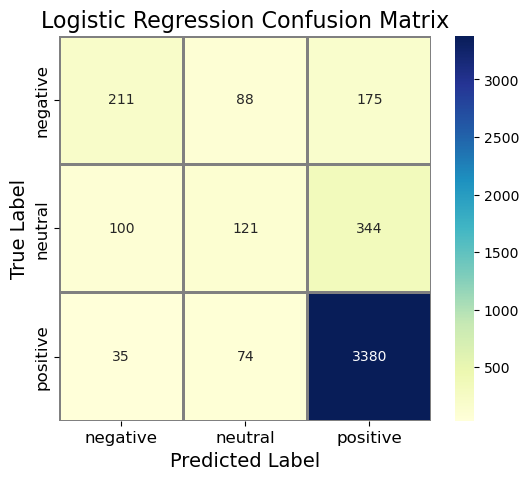

In [15]:
# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

X = df['processed_text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
print("Training the Logistic Regression model...")
log_reg_model.fit(X_train_tfidf, y_train)
print("Model training complete.")

y_pred = log_reg_model.predict(X_test_tfidf)
print("\nClassification Report Preview:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='gray')

plt.title('Logistic Regression Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout

In [5]:
#Topic Modeling using NMF
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# We use the 'processed_text' for this task
docs = df['processed_text'].tolist()

# --- Vectorize the Text using TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(docs)

# --- Initialize and Train the NMF Model ---
print("\nTraining the NMF topic model... (This may take a minute)")
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)
print("NMF model training complete.")

# --- Inspect the Results ---
print("\nTop 10 Topics Discovered by NMF:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"\nKeywords for Topic {topic_idx}:")
    print([feature_names[i] for i in topic.argsort()[-10:][::-1]])
    if topic_idx == 2:  # Show only first 3 topics
        break


Training the NMF topic model... (This may take a minute)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


NMF model training complete.

Top 10 Topics Discovered by NMF:

Keywords for Topic 0:
['look', 'would', 'really', 'back', 'nice', 'material', 'pretty', 'much', 'didnt', 'also']

Keywords for Topic 1:
['love', 'absolutely', 'color', 'style', 'feel', 'detail', 'design', 'soft', 'comfy', 'beautiful']

Keywords for Topic 2:
['size', 'true', 'ordered', 'usual', 'smaller', 'order', 'normal', 'fit', 'would', 'regular']


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Training, Evaluation & Tuning


In [6]:
import numpy as np
import random

# --- Set a Global Random Seed ---
# This ensures that any function using randomness will produce the same results.
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

print(f"Random seeds fixed to {SEED} for reproducibility.")

Random seeds fixed to 42 for reproducibility.


--- Evaluation of Logistic Regression Model ---

Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.45      0.51       474
     neutral       0.43      0.21      0.29       565
    positive       0.87      0.97      0.91      3489

    accuracy                           0.82      4528
   macro avg       0.63      0.54      0.57      4528
weighted avg       0.79      0.82      0.79      4528


Confusion Matrix:


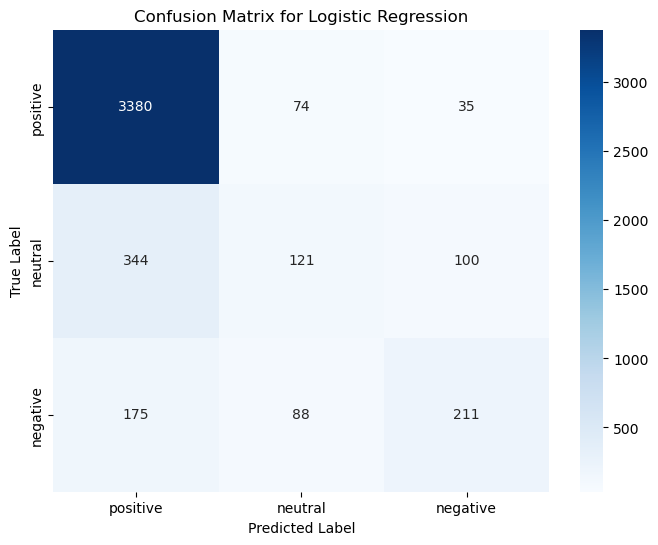

In [ ]:
#--- Evaluation of Logistic Regression Model ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Generate Predictions on the Test Set ---
# We already have y_test (true labels) and y_pred (model's predictions) from the last step
# If not, you can regenerate them:
# y_pred = log_reg_model.predict(X_test_tfidf)

print("--- Evaluation of Logistic Regression Model ---")

# --- Print Classification Report ---
# This gives us precision, recall, and f1-score for each class.
print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)

# --- Visualize the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
#Evaluation and hyperparameter tuning of the Logistic Regression model using Optuna and MLflow
# Install necessary libraries

import optuna
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# --- Set up MLflow Experiment ---
mlflow.set_experiment("Sentiment_Analysis_Tuning")

# This is the function Optuna will optimize.
# It trains a model with a given set of hyperparameters and returns a score.
def objective(trial):
    # We tell MLflow to start a new "run" for this trial
    with mlflow.start_run(nested=True):
        # 1. Suggest Hyperparameters for Optuna to try
        c_param = trial.suggest_float('C', 1e-2, 1e2, log=True)
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        
        # Log these parameters with MLflow
        mlflow.log_params(trial.params)

        # 2. Train the model with the suggested hyperparameters
        model = LogisticRegression(C=c_param, solver=solver, max_iter=1000, random_state=SEED)
        model.fit(X_train_tfidf, y_train)

        # 3. Evaluate the model
        y_pred_eval = model.predict(X_test_tfidf)
        # We use the 'weighted' F1-score to account for class imbalance
        f1 = f1_score(y_test, y_pred_eval, average='weighted')
        
        # Log the result with MLflow
        mlflow.log_metric('f1_weighted', f1)

    # 4. Return the score for Optuna
    return f1

# --- Run the Optimization ---
# We tell Optuna we want to 'maximize' the F1 score.
study = optuna.create_study(direction='maximize')

# Start the parent MLflow run
with mlflow.start_run(run_name="Optuna_Tuning_Run"):
    study.optimize(objective, n_trials=20) # Run 20 trials to find the best params

# --- Print Best Results ---
print("\n--- Optuna Hyperparameter Tuning Results ---")
print(f"Best trial F1-score: {study.best_value}")
print("Best parameters found: ", study.best_params)

[I 2025-08-25 14:17:15,120] A new study created in memory with name: no-name-854ed78b-9e3b-4572-adcf-f5a966bb863d
[I 2025-08-25 14:17:15,316] Trial 0 finished with value: 0.8060626973081576 and parameters: {'C': 6.45289834053062, 'solver': 'saga'}. Best is trial 0 with value: 0.8060626973081576.
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
[I 2025-08-25 14:17:15,471] Trial 1 finished with value: 0.8012749424995534 and parameters: {'C': 18.176056743118433, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8060626973081576.
[I 2025-08-25 14:17:15,968] Trial 2 finished with value: 0.7922599085613713 and parameters: {'C': 30.824152760974943


--- Optuna Hyperparameter Tuning Results ---
Best trial F1-score: 0.8060626973081576
Best parameters found:  {'C': 6.45289834053062, 'solver': 'saga'}


In [ ]:
# Evaluation of NMF Model

print("\n--- Evaluation of NMF Model ---")

# --- Get Topic Summaries ---
print("Top 10 Discovered Topics:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"\nTopic #{topic_idx}:")
    print("Keywords:", [feature_names[i] for i in topic.argsort()[-10:][::-1]])
    if topic_idx == 9:  # Show top 10 topics
        break

# --- Deep Dive into a Specific Topic ---
TOPIC_ID = 1
print(f"\nInspecting Topic #{TOPIC_ID}...")

# 1. Get the keywords
keywords = [feature_names[i] for i in nmf_model.components_[TOPIC_ID].argsort()[-10:][::-1]]
print(f"Keywords: {keywords}")

# 2. Get the most representative reviews for this topic
# Find the top documents for this topic by sorting nmf_topics[:, TOPIC_ID]
top_doc_indices = nmf_topics[:, TOPIC_ID].argsort()[::-1][:5]
print("\nRepresentative Reviews:")
for idx in top_doc_indices:
    print(f"- {docs[idx]}")

# --- Tuning NMF with a smaller topic count for more granular topics ---
print("\n--- Tuning NMF with more topics (n_components=15) ---")
nmf_granular_model = NMF(n_components=15, random_state=42)
nmf_granular_topics = nmf_granular_model.fit_transform(tfidf)

print("New model trained with n_components=15.")
print("Topic Count (original model):", nmf_model.n_components)
print("Topic Count (granular model):", nmf_granular_model.n_components)

print("\nNew, more granular topics:")
for topic_idx, topic in enumerate(nmf_granular_model.components_[:10]):
    print(f"\nTopic #{topic_idx}:")
    print("Keywords:", [feature_names[i] for i in topic.argsort()[-10:][::-1]])


--- Evaluation of NMF Model ---
Top 10 Discovered Topics:

Topic #0:
Keywords: ['look', 'would', 'really', 'back', 'nice', 'material', 'pretty', 'much', 'didnt', 'also']

Topic #1:
Keywords: ['love', 'absolutely', 'color', 'style', 'feel', 'detail', 'design', 'soft', 'comfy', 'beautiful']

Topic #2:
Keywords: ['size', 'true', 'ordered', 'usual', 'smaller', 'order', 'normal', 'fit', 'would', 'regular']

Topic #3:
Keywords: ['great', 'look', 'quality', 'fall', 'fit', 'summer', 'piece', 'work', 'dressed', 'style']

Topic #4:
Keywords: ['small', 'large', 'run', 'medium', 'usually', 'ordered', 'big', 'little', 'normally', 'extra']

Topic #5:
Keywords: ['jean', 'pant', 'pair', 'skinny', 'legging', 'look', 'pilcro', 'stretch', 'leg', 'black']

Topic #6:
Keywords: ['one', 'bought', 'compliment', 'got', 'store', 'many', 'time', 'black', 'sale', 'get']

Topic #7:
Keywords: ['fit', 'perfect', 'perfectly', 'length', 'well', 'petite', 'lb', 'flattering', 'ordered', 'long']

Topic #8:
Keywords: ['c

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


New model trained with n_components=15.
Topic Count (original model): 10
Topic Count (granular model): 15

New, more granular topics:

Topic #0:
Keywords: ['look', 'would', 'really', 'back', 'nice', 'pretty', 'material', 'way', 'good', 'also']

Topic #1:
Keywords: ['love', 'absolutely', 'style', 'color', 'comfy', 'feel', 'detail', 'design', 'everything', 'dressed']

Topic #2:
Keywords: ['size', 'true', 'ordered', 'smaller', 'usual', 'order', 'normal', 'larger', 'would', 'regular']

Topic #3:
Keywords: ['great', 'look', 'quality', 'fall', 'summer', 'piece', 'comfy', 'dressed', 'work', 'style']

Topic #4:
Keywords: ['small', 'large', 'run', 'medium', 'usually', 'ordered', 'big', 'little', 'normally', 'extra']

Topic #5:
Keywords: ['jean', 'skinny', 'pair', 'look', 'legging', 'boot', 'worn', 'pilcro', 'white', 'stretch']

Topic #6:
Keywords: ['compliment', 'many', 'got', 'wore', 'received', 'time', 'get', 'lot', 'ive', 'worn']

Topic #7:
Keywords: ['perfect', 'length', 'petite', 'long', '